In [1]:
import numpy as np
from itertools import product
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT

def circuit_builder(states, n0, n2):
    """ Create a list of n-qubit quantum circuits "qcs", each initialized 
    using the array "states". For each circuit
        1. Perform QFT
        2. Apply IQFT on the first (n0 - n2)//2 qubits
        3. Discard (n0 - n2)//2 qubits from the middle of the register, then 
            perform a measurement of the remaining qubits and store the 
            results in a classical register of n2 bits 
    Return "qcs". """
    
    ntilde = (n0 - n2)//2 # Total number of qubits removed aat each Step
    n1 =  n0 - ntilde # Number of qubits kept, before IQFT is applied
    
    qcs = []
    for idx in range(states.shape[0]):
        q = QuantumRegister(n0)
        c = ClassicalRegister(n2)
        qc = QuantumCircuit(q,c)
        
        qc.initialize(states[idx], q)    
        
        qc.h(q) # Optional, improves the reconstruction
        
        # Apply QFT on the full circuit
        qc.compose(QFT(num_qubits=n0, approximation_degree=0, do_swaps=True, \
                       inverse=False, insert_barriers=True, name='QFT'), \
                       inplace = True)
        
        qc.barrier()
        
        # Apply IQFT on the first n1 qubits (Rule 1)
        qc.compose(QFT(num_qubits=n1, approximation_degree=0, do_swaps=True, \
                       inverse=True, insert_barriers=True, name='IQFT'), \
                       qubits = q[0:n1], inplace = True)
        
        creg_idx = 0
        for idx in range(n1):  
            if n0//2 - ntilde <= idx <= n0//2 - 1: 
                continue # Qubit discarded from the measurement (Rule 2)
            qc.h(q[idx]) # Optional, improves the reconstruction
            qc.measure(q[idx],c[creg_idx])
            creg_idx += 1
        qcs.append(qc)
        
    return qcs

def reconstruction(qcs, n2, shots, norm):
    """ Simulate "qcs" with a given number of "shots". 
    Return an array "out_freq" with shape (S, 2**n2), describing the output 
    frequencies of each circuit and eventually rescaled using the corresponding
    component of "norm". """
    
    out_freq = np.zeros((len(qcs), 2**n2)) # Shape (S, 2**n2)
    
    for idx in range(len(qcs)):
        simulator = AerSimulator()
        qcs[idx] = transpile(qcs[idx], simulator)
        result = simulator.run(qcs[idx], shots = shots).result()
        
        counts = result.get_counts(qcs[idx]) # Counts at the output of qcs[idx]
        tot = sum(counts.values(), 0.0)
        prob = {key: val/tot for key, val in counts.items()} # Frequencies
        
        out = np.zeros(2**n2) # Shape (1, 2**n2)
        
        # Generate all the possible n2 qubits configurations
        cfgs = list(product(('0','1'), repeat = n2))
        cfgs = [''.join(cfg) for cfg in cfgs] 
        for i in range(2**n2):
            out[i] = prob.get(cfgs[i], 0)
            
        out_freq[idx,:] = out[:]*norm[idx]
    
    return out_freq

In [2]:
import numpy as np

def rgb2gray(rgb):
    """ Convert an RGB digital image to greyscale. """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def vectorization(img, Cr, Cc, renorm = False):
    """ Vectorize the image as follows. 
        1. Split the original (Mr, Mc) image into S equal-sized patches of 
            shape (Cr, Cc). Then, vectorize each patch and collect all 
            in a (S, Cr*Cc) array, called "vect_patches".
        2. Normalize each (Cr*Cc) vector to the intensity of the corresponding 
            (Cr, Cc) patch. When "renorm" is set to True, save the 
            normalization constants in the array "norm" for final decoding. 
            Otherwise, erase this information by setting "norm" equal to an 
            array of 1s.
        3. Define an array called "states" with shape (S, Cr*Cc), obtained as 
            the elementwise square root of "vect_patches".
    Return the couple (states, norm). """
    
    Mr, Mc = img.shape # Shape of the original image (#rows, #columns)
    
    # The image is split into N patches, each of shape (Cr,Cc)
    patches =  (img.reshape(Mc//Cr, Cr, -1, Cc).swapaxes(1, 2)\
                .reshape(-1, Cr, Cc)) # Shape (S, Cr, Cc)
    
    # Vectorization
    vect_patches = np.reshape(patches,\
                              (patches.shape[0],Cr*Cc)) # Shape (S, Cr*Cc)
    
    # Normalization
    states = np.zeros((patches.shape[0],Cr*Cc)) # Shape (S, Cr*Cc)
    
    norm = np.zeros(patches.shape[0]) # Shape (S, 1)
    for idx in range(patches.shape[0]):
        norm[idx] = vect_patches[idx].sum()
        if norm[idx] == 0:
            raise ValueError('Pixel value is 0') 
        tmp = vect_patches[idx]/norm[idx]
        states[idx] = np.sqrt(tmp)
    if renorm == False:
        norm = np.ones(patches.shape[0])
        
    return (states, norm)

def devectorization(out_freq):
    """ Reconstruct an image using the simulation output. The function 
    operates as follows:
        1. Devectorize each of the S arrays in "out_freq" to 
            a (2**(n2/2), 2**(n2/2)) patch.
        2. Recombine the patches in a single object called "decoded_img" with 
        shape (Mr, Mc). 
    Return an image with number of pixels equal to the length of "out_freq" 
    times the number of patches. """
    
    S = out_freq.shape[0] # Number of patches
    nrow = int(np.sqrt(out_freq.shape[1])) # Number of rows of each patch
    ncol = nrow # Number of columns of each compressed patch
    
    decoded_patches = np.reshape(out_freq,\
                      (out_freq.shape[0], nrow, ncol)) # Shape (S, nrow, ncol)
    
    im_h, im_w = nrow*int(np.sqrt(S)), ncol*int(np.sqrt(S)) # Final shape
    
    decoded_img = np.zeros((im_w, im_h)) # Initialization
    
    idx = 0
    for row in np.arange(im_h - nrow + 1, step=nrow):
        for col in np.arange(im_w - ncol + 1, step=ncol):
            decoded_img[row:row+nrow, col:col+ncol] = decoded_patches[idx]
            idx += 1
            
    return decoded_img

The resolution is 1285 x 1080 pixels. There are 1387800 pixels.


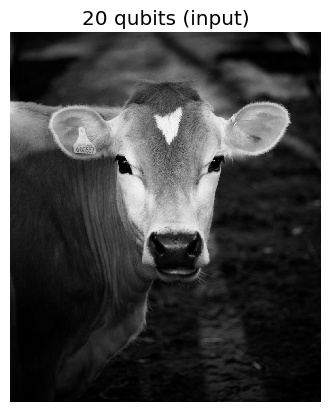

The shape of the vectorized image is (1387800,). It will be loaded in 1387800 circuit(s) of 20 qubits.


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

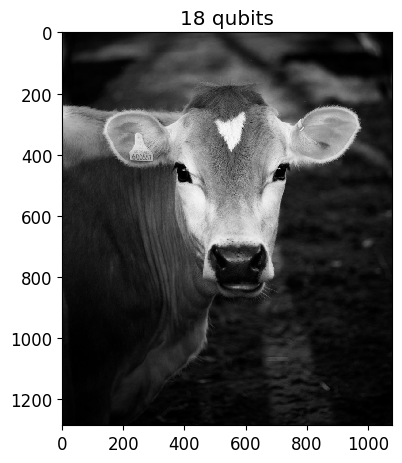

 11%|█████████▎                                                                          | 1/9 [00:00<00:02,  3.26it/s]

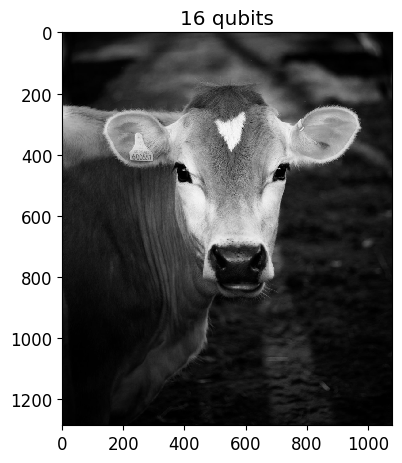

 22%|██████████████████▋                                                                 | 2/9 [00:00<00:01,  3.60it/s]

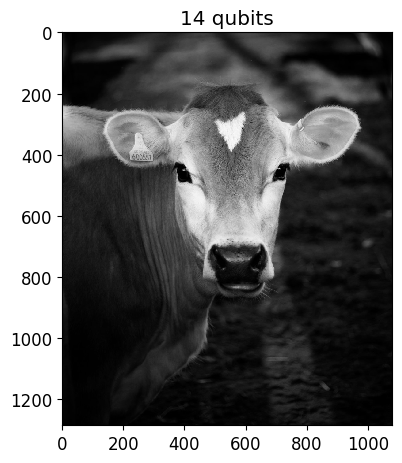

 33%|████████████████████████████                                                        | 3/9 [00:00<00:01,  3.31it/s]

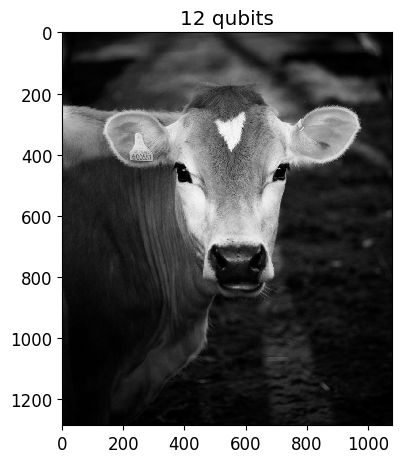

 44%|█████████████████████████████████████▎                                              | 4/9 [00:01<00:01,  3.06it/s]

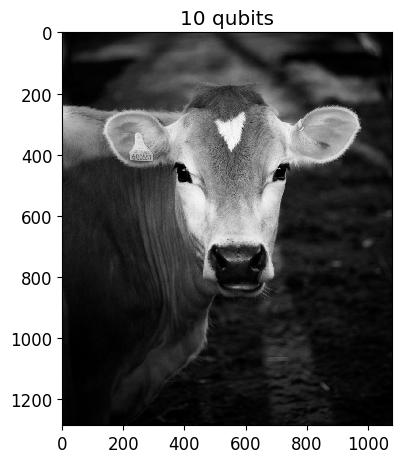

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:01<00:01,  3.10it/s]

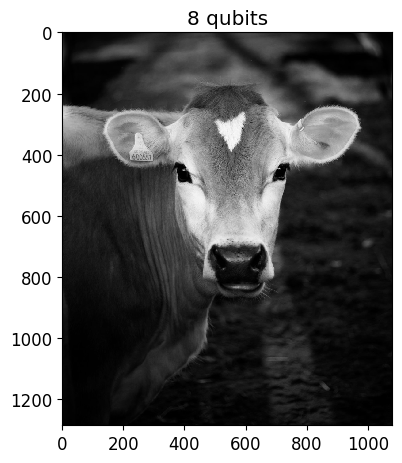

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:01<00:00,  3.25it/s]

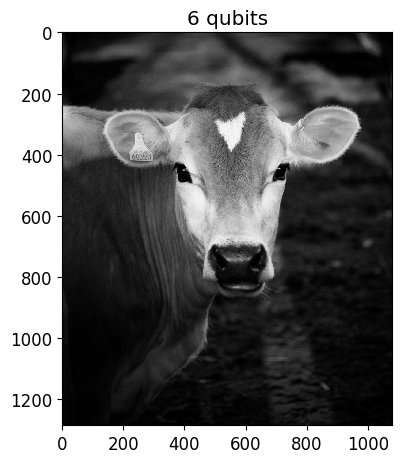

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:02<00:00,  3.23it/s]

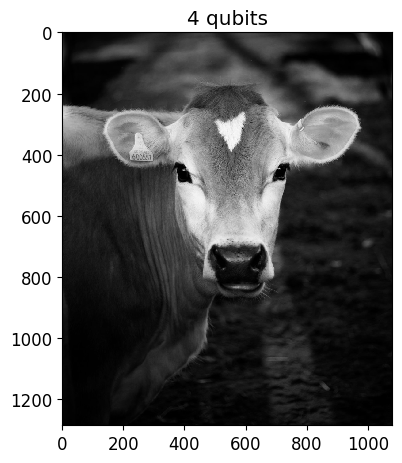

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:02<00:00,  3.05it/s]

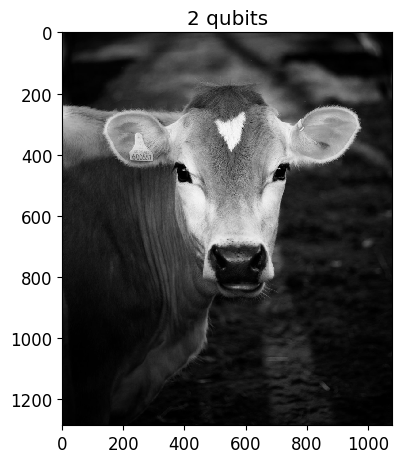

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.15it/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2

# Function to convert RGB to grayscale
def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Function to vectorize the image
def vectorization(image):
    """Convert an image to a 1D feature vector."""
    return image.flatten()

# Function to devectorize the image
def devectorization(vector, original_shape):
    """Convert a 1D feature vector back to the original image shape."""
    return vector.reshape(original_shape)

# Function stubs for circuit_builder and reconstruction
def circuit_builder(states, n0, n2):
    # Placeholder for the actual implementation
    return states  # Replace with actual circuit building logic

def reconstruction(qcs, n2, shots, norm):
    # Placeholder for the actual implementation
    return qcs  # Replace with actual reconstruction logic

# Load the input image
img = mpimg.imread(r"D:\6m_NIC\images\cow.jpeg") 

if len(img.shape) != 2:
    img = rgb2gray(img)  # Convert an RGB image to grayscale

bitdepth = 8  # Depth
black, white = 0, 2 ** bitdepth - 1

plt.rcParams.update({'font.size': 12})

Mr, Mc = img.shape
print('The resolution is', Mr, 'x', Mc, 'pixels.', 'There are', np.size(img), 'pixels.')

plt.imshow(img, cmap='gray', vmin=black, vmax=white, interpolation='none')
plt.title('%i qubits (input)' % np.log2(Mr * Mc))
plt.axis('off')
plt.show()

Cr, Cc = Mr, Mc
states = vectorization(img)
n0 = int(np.log2(Cr * Cc))  # Number of qubits for each circuit

print('The shape of the vectorized image is ', states.shape, '. It will be loaded in ', states.shape[0],
      ' circuit(s) of ', n0, ' qubits.', sep='')

for n2 in tqdm(range(n0 - 2, 0, -2)):
    shots = 2 ** (n2 + bitdepth)

    states = vectorization(img)
    qcs = circuit_builder(states, n0, n2)
    out_freq = reconstruction(qcs, n2, shots, None)  # Pass norm as required
    final_img = devectorization(out_freq, (Cr, Cc))

    # Scale the final image to avoid overflow
    final_img = final_img / final_img.max() * 255  # Scale to 0-255 range
    final_img = np.clip(final_img, 0, 255)  # Ensure values are within 0-255
    final_img = final_img.astype(np.uint8)  # Convert back to uint8

    plt.imshow(final_img, cmap='gray', vmin=black, vmax=white, interpolation='none')
    plt.title('%i qubits' % n2)
    plt.tight_layout()
    plt.axis('on')
    plt.show()


In [8]:
print(f'Compression Ratio after {n2} qubits: {compression_ratio:.2f}')

Compression Ratio after 2 qubits: 1.00


In [2]:
pip install pylatexenc


  Using cached pylatexenc-2.10-py3-none-any.whl


In [4]:
pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm


  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/78.4 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/78.4 kB ? eta -:--:--
   --------------- ------------------------ 30.7/78.4 kB 262.6 kB/s eta 0:00:01
   ------------------------------------ --- 71.7/78.4 kB 491.5 kB/s eta 0:00:01
   ---------------------------------------- 78.4/78.4 kB 483.1 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install matplotlib

  Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp311-cp311-win_amd64.whl.metadata (167 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp311-cp311-win_amd64.whl (217 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl (56 kB)
Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.1.4-py3-none-any.whl (104 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.Collecting numpy
  Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl (12.9 MB)




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install qiskit

  Using cached rustworkx-0.15.1-cp38-abi3-win_amd64.whl.metadata (10 kB)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-win_amd64.whl.metadata (1.2 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.6 MB 640.0 kB/s eta 0:00:08
   ---------------------------------------- 0.0/4.6 MB 487.6 kB/s eta 0:00:10
    --------------------------------------- 0.1/4.6 MB 737.3 kB/s eta 0:00:07
   - -------------------------------------- 0.2/4.6 MB 1.0 MB/s eta 0:00:05
   -- ------------------------------------- 0.3/4.6 MB 1.3 MB/s eta 0:00:04
   ---- --


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install qiskit_aer

  Using cached qiskit_aer-0.15.1-cp311-cp311-win_amd64.whl.metadata (8.2 kB)
Using cached qiskit_aer-0.15.1-cp311-cp311-win_amd64.whl (9.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
